In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

import numpy as np
import h5py

import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

In [ ]:
import shutil

drive_path = "/content/drive/MyDrive/dataset/"
local_path = "/content/"

# Copy dataset files from Drive to Colab
shutil.copy(f"{drive_path}ITOP_side_train_depth_map.h5.gz", local_path)
shutil.copy(f"{drive_path}ITOP_side_train_labels.h5.gz", local_path)
shutil.copy(f"{drive_path}ITOP_side_test_depth_map.h5.gz", local_path)
shutil.copy(f"{drive_path}ITOP_side_test_labels.h5.gz", local_path)

print("✅ Files copied successfully to Colab.")


✅ Files copied successfully to Colab.


In [ ]:
!gunzip /content/ITOP_side_train_depth_map.h5.gz
!gunzip /content/ITOP_side_train_labels.h5.gz
!gunzip /content/ITOP_side_test_depth_map.h5.gz
!gunzip /content/ITOP_side_test_labels.h5.gz


In [ ]:
import h5py
import numpy as np

def inspect_h5_file(file_path):
    with h5py.File(file_path, 'r') as f:
        print("Keys and shapes in the HDF5 file:\n")
        for key in f.keys():
            data = f[key]
            print(f"Key: '{key}'")
            print(f"  Shape: {data.shape}")
            print(f"  Dtype: {data.dtype}")

            # Print a small sample of data (first item or first few rows)
            try:
                if data.ndim == 1:
                    print(f"  Sample: {data[:5]}")
                elif data.ndim == 2:
                    print(f"  Sample:\n{data[:2, :5]}")
                elif data.ndim == 3:
                    print(f"  Sample (first item):\n{data[0, :5, :5]}")
                else:
                    print(f"  Sample: {data[()][:5]}")
            except Exception as e:
                print(f"  Could not preview data: {e}")

            print("-" * 50)

# Example usage:
print("ITOP_side_test_depth_map.h5")
inspect_h5_file("/content/ITOP_side_test_depth_map.h5")
print("\nITOP_side_train_depth_map.h5")
inspect_h5_file("/content/ITOP_side_train_depth_map.h5")
print("\nITOP_side_test_labels.h5")
inspect_h5_file("/content/ITOP_side_test_labels.h5")
print("\nITOP_side_train_labels.h5")
inspect_h5_file("/content/ITOP_side_train_labels.h5")


ITOP_side_test_depth_map.h5
Keys and shapes in the HDF5 file:

Key: 'data'
  Shape: (10501, 240, 320)
  Dtype: float16
  Sample (first item):
[[0.    0.    0.    2.156 2.156]
 [0.    0.    0.    2.156 2.156]
 [0.    0.    0.    2.156 2.156]
 [0.    0.    0.    2.156 2.156]
 [0.    0.    0.    2.156 2.156]]
--------------------------------------------------
Key: 'id'
  Shape: (10501,)
  Dtype: |S8
  Sample: [b'00_00000' b'00_00001' b'00_00002' b'00_00003' b'00_00004']
--------------------------------------------------

ITOP_side_train_depth_map.h5
Keys and shapes in the HDF5 file:

Key: 'data'
  Shape: (39795, 240, 320)
  Dtype: float16
  Sample (first item):
[[0.    0.    0.    2.129 2.129]
 [0.    0.    0.    2.129 2.129]
 [0.    0.    0.    2.145 2.145]
 [0.    0.    0.    2.145 2.145]
 [0.    0.    0.    2.145 2.145]]
--------------------------------------------------
Key: 'id'
  Shape: (39795,)
  Dtype: |S8
  Sample: [b'04_00000' b'04_00001' b'04_00002' b'04_00003' b'04_00004']
---

In [ ]:
import torch
import numpy as np
import h5py
from torch.utils.data import Dataset
from torchvision import transforms

class ITOPDataset(Dataset):
    def __init__(self, depth_path, label_path, split='train', num_samples=None, only_valid=True, augment=False):
        self.depth_path = depth_path
        self.label_path = label_path
        self.split = split
        self.num_samples = num_samples
        self.only_valid = only_valid
        self.augment = augment

        self.fx = 285.71
        self.fy = 285.71
        self.cx = 160
        self.cy = 120

        self.base_transform = transforms.ToTensor()

        # Augmentation transforms
        self.aug_transforms = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),

        ])

        # Load depth
        with h5py.File(self.depth_path, 'r') as f:
            self.depth_images = f['data'][:]

        # Load labels
        with h5py.File(self.label_path, 'r') as f:
            print(f"Keys in label file: {list(f.keys())}")
            self.joints = f['real_world_coordinates'][:]
            self.visibility = f['visible_joints'][:]
            self.is_valid = f['is_valid'][:] if 'is_valid' in f else np.ones(len(self.joints), dtype=bool)

        # Filter to only valid samples
        if self.only_valid:
            valid_mask = self.is_valid.astype(bool)
            self.depth_images = self.depth_images[valid_mask]
            self.joints = self.joints[valid_mask]
            self.visibility = self.visibility[valid_mask]
            self.is_valid = self.is_valid[valid_mask]

        # Optionally subset
        if num_samples:
            self.depth_images = self.depth_images[:num_samples]
            self.joints = self.joints[:num_samples]
            self.visibility = self.visibility[:num_samples]
            if self.only_valid:
                self.is_valid = self.is_valid[:num_samples]

    def __len__(self):
        return len(self.depth_images)

    def __getitem__(self, idx):
        depth = self.depth_images[idx].astype(np.float32)
        depth = (depth - depth.min()) / (depth.max() - depth.min())
        depth = np.expand_dims(depth, axis=0)

        # Convert to tensor
        depth_tensor = torch.tensor(depth)

        # Apply augmentation
        if self.augment:
            depth_tensor = self.aug_transforms(depth_tensor)


        depth_tensor = depth_tensor.squeeze(0).unsqueeze(0)

        # Get 3D joint locations
        joints = self.joints[idx]
        visibility = self.visibility[idx]

        # Prevent division by zero
        joints[:, 2] = np.clip(joints[:, 2], 1e-3, None)


        u = (joints[:, 0] * self.fx) / joints[:, 2] + self.cx
        v = (joints[:, 1] * self.fy) / joints[:, 2] + self.cy
        joints_2d = np.stack((u, v), axis=-1)

        return {
            'depth': depth_tensor,  # Tensor shape: (1, H, W)
            'joints_3d': torch.tensor(joints, dtype=torch.float32),  # (15, 3)
            'joints_2d': torch.tensor(joints_2d, dtype=torch.float32),  # (15, 2)
            'visibility': torch.tensor(visibility, dtype=torch.float32),
            'image_coordinate': torch.tensor(joints_2d, dtype=torch.float32),
            'valid': bool(self.is_valid[idx]) if self.only_valid else True
        }


In [ ]:
train_dataset = ITOPDataset(
    depth_path='ITOP_side_train_depth_map.h5',
    label_path='ITOP_side_train_labels.h5',
    split='train',
    only_valid=True,
    augment=True
)

test_dataset = ITOPDataset(
    depth_path='ITOP_side_test_depth_map.h5',
    label_path='ITOP_side_test_labels.h5',
    split='test',
    only_valid=True,
    augment=False
)




Keys in label file: ['id', 'image_coordinates', 'is_valid', 'real_world_coordinates', 'segmentation', 'visible_joints']
Keys in label file: ['id', 'image_coordinates', 'is_valid', 'real_world_coordinates', 'segmentation', 'visible_joints']


In [ ]:
def visualize_sample(dataset, index=0):
    sample = dataset[index]
    if 'valid' in sample and not sample['valid']:
        print(f"Skipping invalid sample at index {index}")
        return

    depth = sample['depth'].squeeze().numpy()
    joints = sample['joints_3d'].numpy()
    visibility = sample['visibility'].numpy()

    # Project 3D joints to 2D for visualization
    joints_2d = project_joints_to_image(joints)

    plt.figure(figsize=(10, 8))
    plt.imshow(depth, cmap='gray')

    # Plot visible joints
    visible_mask = visibility > 0.5
    plt.scatter(
        joints_2d[visible_mask, 0],
        joints_2d[visible_mask, 1],
        c='green', s=50, marker='o'
    )
    plt.title("Depth Map with Ground Truth Joints")
    plt.colorbar()
    plt.show()
def project_joints_to_image(joints_3d,
                            fx=285.71, fy=285.71,
                            cx=160, cy=120,
                            image_height=240):
    """Project 3D joints (in meters) to 2D image coordinates"""
    z = joints_3d[:, 2]
    z[z < 0.001] = 0.001  # Prevent division by zero

    x = (joints_3d[:, 0] * fx) / z + cx
    y = (joints_3d[:, 1] * fy) / z + cy

    # Flip Y to match image coordinate system
    y = image_height - y

    return np.stack([x, y], axis=1)




Checking training sample:


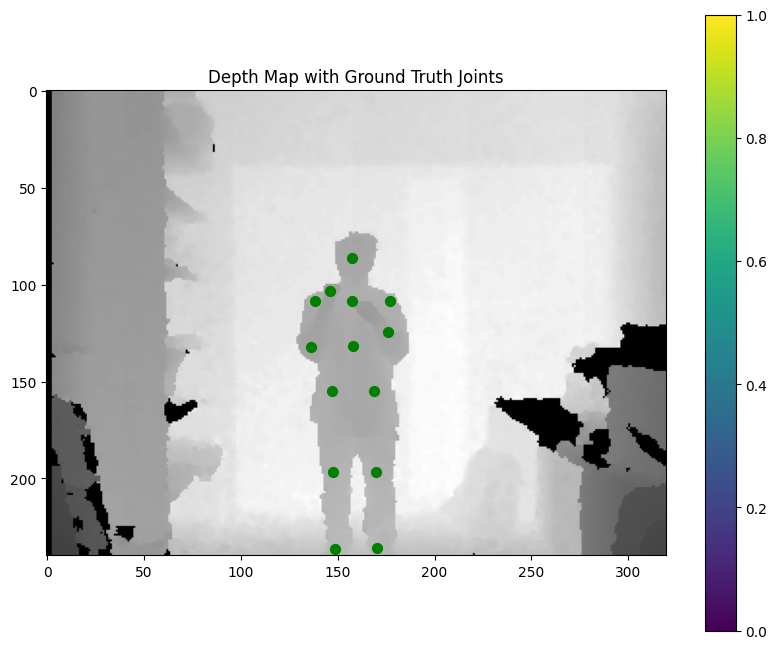


Checking test sample:


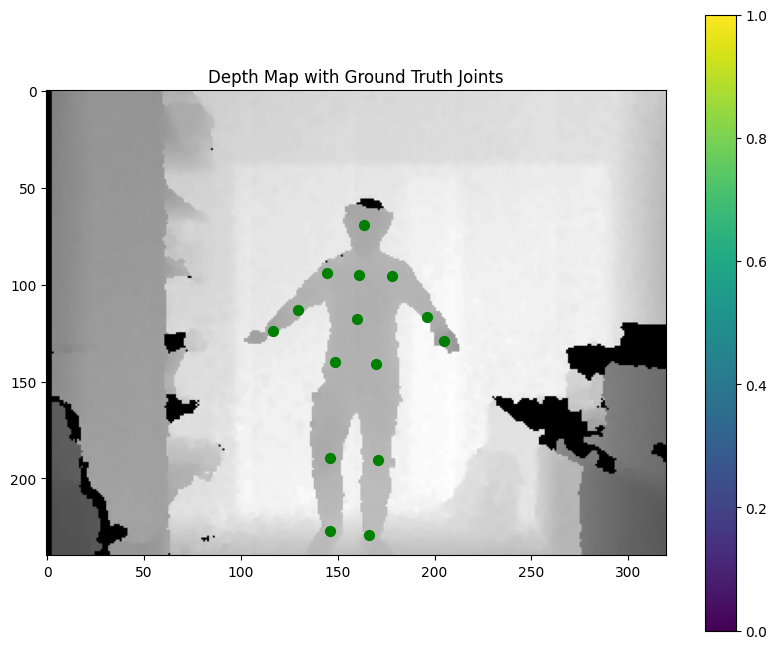


Visualizing multiple training samples:
Sample 1/3 (index 9952):


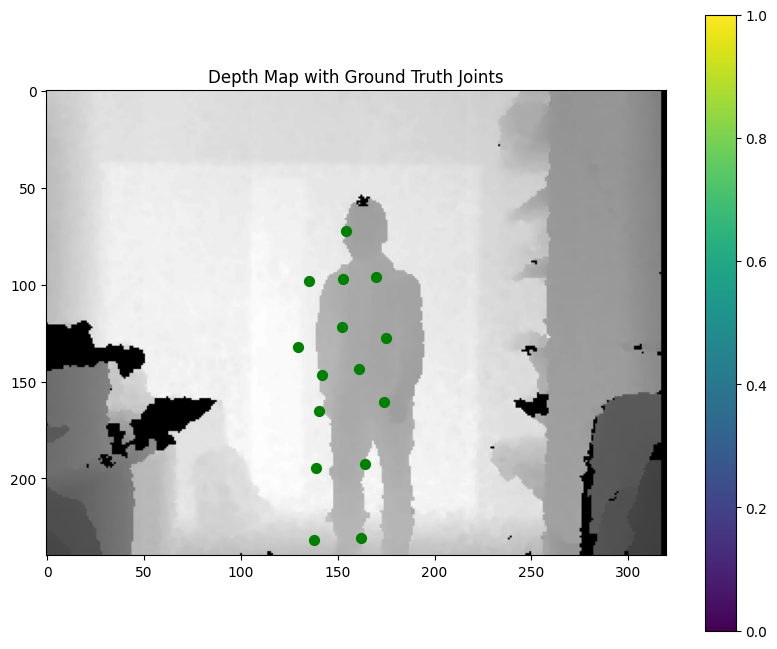

Sample 2/3 (index 318):


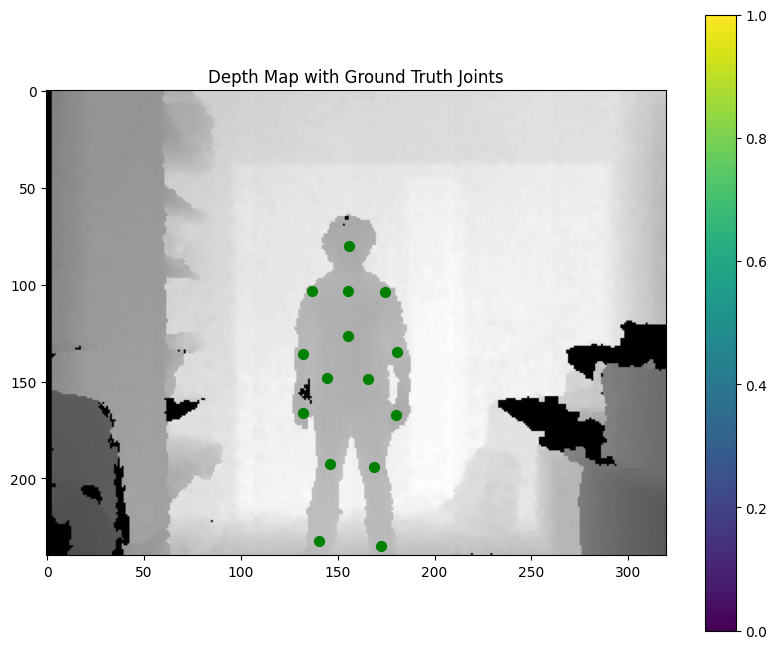

Sample 3/3 (index 4849):


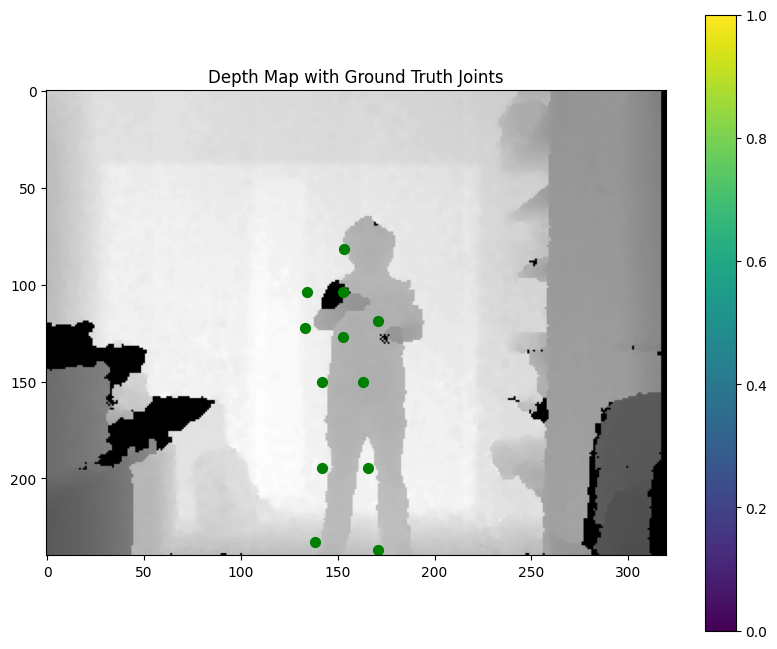


Debugging coordinate transformation:
3D Joint Coordinates (first 3 joints):
[[-0.02424622  0.33740234  2.859375  ]
 [-0.02445984  0.11578369  2.8769531 ]
 [-0.22033691  0.11480713  2.8808594 ]]

2D Projected Coordinates (first 3 joints):
[[157.5773    86.286606]
 [157.57089  108.501526]
 [138.14803  108.61397 ]]

Joint Statistics:
Mean 3D position: [-0.0260905  -0.27758992  2.871224  ]
Min 3D position: [-0.22692871 -1.2587891   2.5234375 ]
Max 3D position: [0.17150879 0.33740234 3.0976562 ]


In [ ]:
def verify_datasets():
    print("Checking training sample:")
    visualize_sample(train_dataset, index=0)

    print("\nChecking test sample:")
    visualize_sample(test_dataset, index=0)

#  verification function
verify_datasets()

def visualize_multiple_samples(dataset, num_samples=3):
    """Visualize multiple samples to verify dataset consistency"""
    indices = np.random.randint(0, len(dataset), size=num_samples)

    for i, idx in enumerate(indices):
        print(f"Sample {i+1}/{num_samples} (index {idx}):")
        visualize_sample(dataset, index=idx)

# Visualize multiple training samples
print("\nVisualizing multiple training samples:")
visualize_multiple_samples(train_dataset)

# Function to debug joint coordinate values
def debug_joint_coordinates(dataset, index=0):
    sample = dataset[index]
    if 'valid' in sample and not sample['valid']:
        print(f" Skipping invalid sample at index {index}")
        return

    joints_3d = sample['joints_3d'].numpy()
    joints_2d = project_joints_to_image(joints_3d)

    print("3D Joint Coordinates (first 3 joints):")
    print(joints_3d[:3])

    print("\n2D Projected Coordinates (first 3 joints):")
    print(joints_2d[:3])

    print("\nJoint Statistics:")
    print(f"Mean 3D position: {np.mean(joints_3d, axis=0)}")
    print(f"Min 3D position: {np.min(joints_3d, axis=0)}")
    print(f"Max 3D position: {np.max(joints_3d, axis=0)}")


print("\nDebugging coordinate transformation:")
debug_joint_coordinates(train_dataset)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ViewpointInvariantPoseNet(nn.Module):
    def __init__(self, num_joints=15, num_iterations=3):
        super(ViewpointInvariantPoseNet, self).__init__()
        self.num_joints = num_joints
        self.num_iterations = num_iterations

        # 1. Feature extraction network (CNN backbone)
        self.feature_extractor = nn.Sequential(

            nn.Conv2d(1, 32, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )

        # Calculate feature map size
        feature_h, feature_w = 15, 20
        feature_dim = 256 * feature_h * feature_w

        # 2. Initial pose estimator
        self.initial_pose_estimator = nn.Sequential(
            nn.Linear(feature_dim, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(1024, num_joints * 3)
        )

        # 3. Iterative Error Feedback (IEF)
        self.pose_embedding = nn.Linear(num_joints * 3, 1024)

        # GRU for iterative refinement
        self.gru = nn.GRU(
            input_size=1024 + feature_dim,
            hidden_size=1024,
            num_layers=1,
            batch_first=True
        )

        # Refinement layer to predict pose delta
        self.pose_refiner = nn.Sequential(
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, num_joints * 3)
        )

        # Joint visibility estimator
        self.visibility_estimator = nn.Sequential(
            nn.Linear(feature_dim, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, num_joints),
            nn.Sigmoid()
        )

    def forward(self, x):
        batch_size = x.size(0)


        if x.dim() == 3:
            x = x.unsqueeze(1)

        # 1. Extract features from depth map
        features = self.feature_extractor(x)
        features_flat = features.view(batch_size, -1)

        # 2. Initial pose estimation
        initial_pose = self.initial_pose_estimator(features_flat)
        initial_pose = initial_pose.view(batch_size, self.num_joints, 3)

        # 3. Iterative refinement with IEF
        current_pose = initial_pose
        pose_estimates = [current_pose]

        for i in range(self.num_iterations):

            current_pose_flat = current_pose.view(batch_size, -1)

            pose_embedded = self.pose_embedding(current_pose_flat)

            combined_features = torch.cat([pose_embedded, features_flat], dim=1)
            combined_features = combined_features.unsqueeze(1)

            gru_out, _ = self.gru(combined_features)
            gru_out = gru_out.squeeze(1)


            pose_delta = self.pose_refiner(gru_out)
            pose_delta = pose_delta.view(batch_size, self.num_joints, 3)


            current_pose = current_pose + pose_delta
            pose_estimates.append(current_pose)


        joint_visibility = self.visibility_estimator(features_flat)


        return current_pose, joint_visibility, pose_estimates

In [ ]:
def train_model(model, train_loader, criterion, optimizer, device, epoch,
                keypoints_mean, keypoints_std):
    model.train()
    running_loss = 0.0
    pose_loss_total = 0.0
    visibility_loss_total = 0.0

    for batch_idx, data in enumerate(train_loader):
        depth = data['depth'].to(device)
        joints = data['joints_3d'].to(device)
        visibility = data['visibility'].to(device)

        # Normalize joints
        joints = (joints - keypoints_mean) / keypoints_std

        optimizer.zero_grad()
        pose_pred, visibility_pred, pose_estimates = model(depth)

        mask = visibility.unsqueeze(-1).repeat(1, 1, 3)
        pose_loss = criterion['pose'](pose_pred * mask, joints * mask)

        for i, pose_est in enumerate(pose_estimates[:-1]):
            weight = 0.5 ** (len(pose_estimates) - i - 1)
            pose_loss += weight * criterion['pose'](pose_est * mask, joints * mask)

        visibility_loss = criterion['visibility'](visibility_pred, visibility)
        loss = pose_loss + 0.1 * visibility_loss

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        running_loss += loss.item()
        pose_loss_total += pose_loss.item()
        visibility_loss_total += visibility_loss.item()

        if batch_idx % 10 == 0:
            print(f'Epoch: {epoch}, Batch: {batch_idx}/{len(train_loader)}, '
                  f'Loss: {loss.item():.4f}, Pose Loss: {pose_loss.item():.4f}, '
                  f'Visibility Loss: {visibility_loss.item():.4f}')

    avg_loss = running_loss / len(train_loader)
    avg_pose_loss = pose_loss_total / len(train_loader)
    avg_visibility_loss = visibility_loss_total / len(train_loader)

    return avg_loss, avg_pose_loss, avg_visibility_loss


In [ ]:
def evaluate_model(model, test_loader, criterion, device,
                   keypoints_mean, keypoints_std):
    model.eval()
    running_loss = 0.0
    total_samples = 0
    mpjpe_total = 0.0

    with torch.no_grad():
        for data in test_loader:
            depth = data['depth'].to(device)
            joints = data['joints_3d'].to(device)
            visibility = data['visibility'].to(device)

            # Normalize GT
            joints = (joints - keypoints_mean) / keypoints_std

            pose_pred, visibility_pred, _ = model(depth)

            #  Unnormalize predictions
            pose_pred = pose_pred * keypoints_std + keypoints_mean
            joints = joints * keypoints_std + keypoints_mean

            mask = visibility.unsqueeze(-1).repeat(1, 1, 3)
            errors = torch.norm(pose_pred * mask - joints * mask, dim=2)
            vis_count = visibility.sum(dim=1)
            batch_mpjpe = torch.sum(errors, dim=1) / torch.clamp(vis_count, min=1)

            batch_size = depth.size(0)
            mpjpe_total += batch_mpjpe.sum().item()
            total_samples += batch_size

            pose_loss = criterion['pose'](pose_pred * mask, joints * mask)
            visibility_loss = criterion['visibility'](visibility_pred, visibility)
            loss = pose_loss + 0.1 * visibility_loss

            running_loss += loss.item() * batch_size

    avg_loss = running_loss / total_samples
    avg_mpjpe = mpjpe_total / total_samples

    return avg_loss, avg_mpjpe


In [ ]:
import torch
print(f"CUDA Available: {torch.cuda.is_available()}")
print(f"CUDA Version: {torch.version.cuda}")


CUDA Available: True
CUDA Version: 12.4


In [ ]:

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau
import time
import datetime

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


model = ViewpointInvariantPoseNet(num_joints=15, num_iterations=3)
model = model.to(device)


print(f"Model initialized with {sum(p.numel() for p in model.parameters() if p.requires_grad):,} trainable parameters")

def mpjpe_loss(pred, target):
    return torch.mean(torch.norm(pred - target, dim=-1))

criterion = {
    'pose': mpjpe_loss,
    'visibility': nn.BCELoss()
}

# optimizer with adjusted learning rate
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)

# Learning rate scheduler
scheduler = ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=5,
    verbose=True,
    min_lr=1e-6
)

# Training parameters
num_epochs = 15
best_mpjpe = float('inf')


Using device: cuda
Model initialized with 362,007,913 trainable parameters


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
import numpy as np
import torch
from torch.utils.data import random_split


batch_size = 32

# Split training data into train and validation sets
val_size = int(0.2 * len(train_dataset))
train_size = len(train_dataset) - val_size

train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

all_train_keypoints = np.vstack([sample['joints_3d'].numpy() for sample in train_dataset])  # (N*15, 3)
keypoints_mean = torch.tensor(np.mean(all_train_keypoints, axis=0), dtype=torch.float32).to(device)
keypoints_std = torch.tensor(np.std(all_train_keypoints, axis=0), dtype=torch.float32).to(device)
print(f"Keypoint mean: {keypoints_mean}")
print(f"Keypoint std: {keypoints_std}")

#  data loaders
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

Keypoint mean: tensor([-0.0702, -0.2677,  2.9415], device='cuda:0')
Keypoint std: tensor([0.1813, 0.5012, 0.1754], device='cuda:0')


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
# Create directories for saving models and results
import os
import time
import datetime
import torch

os.makedirs('models', exist_ok=True)
os.makedirs('results', exist_ok=True)

# Training history
history = {
    'train_loss': [],
    'train_pose_loss': [],
    'train_vis_loss': [],
    'val_loss': [],
    'val_mpjpe': [],
    'learning_rates': []
}

# Early stopping setup
early_stopping_patience = 2
early_stopping_counter = 0
best_mpjpe = float('inf')

# Function to clean up old checkpoints and keep only the best one
def cleanup_checkpoints(best_epoch):
    for file in os.listdir('models'):
        if file.startswith('viewpoint_invariant_pose_model_epoch_') and file.endswith('.pth'):
            os.remove(os.path.join('models', file))
    print(f"Cleaned up old checkpoints, keeping only the best model from epoch {best_epoch}")

# Training loop
print("Starting training...")
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    start_time = time.time()

    # Train for one epoch
    train_loss, train_pose_loss, train_vis_loss = train_model(
        model, train_loader, criterion, optimizer, device, epoch+1, keypoints_mean, keypoints_std
    )

    # Evaluate on test set
    val_loss, val_mpjpe = evaluate_model(model, val_loader, criterion, device, keypoints_mean, keypoints_std)


    scheduler.step(val_loss)
    current_lr = optimizer.param_groups[0]['lr']


    history['train_loss'].append(train_loss)
    history['train_pose_loss'].append(train_pose_loss)
    history['train_vis_loss'].append(train_vis_loss)
    history['val_loss'].append(val_loss)
    history['val_mpjpe'].append(val_mpjpe)
    history['learning_rates'].append(current_lr)

    # Save  model state
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'val_mpjpe': val_mpjpe,
    }, f'models/latest_viewpoint_invariant_pose_model.pth')

    if val_mpjpe < best_mpjpe:
        best_mpjpe = val_mpjpe
        best_epoch = epoch + 1

        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'val_mpjpe': val_mpjpe,
        }, 'models/best_viewpoint_invariant_pose_model.pth')

        # Save training history
        torch.save(history, 'results/training_history.pth')

        print(f"✅ New best model saved with MPJPE: {best_mpjpe*100:.2f} cm")

        # Reset early stopping counter
        early_stopping_counter = 0
    else:
        # Increment early stopping counter
        early_stopping_counter += 1
        print(f"⚠️ No improvement in MPJPE for {early_stopping_counter} epochs")

    # Calculate time elapsed
    time_elapsed = time.time() - start_time
    time_str = str(datetime.timedelta(seconds=int(time_elapsed)))

    # Print epoch summary
    print(f"Epoch {epoch+1} completed in {time_str}")
    print(f"Train Loss: {train_loss:.4f}, Train Pose Loss: {train_pose_loss:.4f}, "
          f"Train Visibility Loss: {train_vis_loss:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val MPJPE: {val_mpjpe*1000:.2f} mm")
    print(f"Learning rate: {current_lr:.8f}")

    # Early stopping check
    if early_stopping_counter >= early_stopping_patience:
        print(f"❌ Early stopping triggered after {early_stopping_patience} epochs without improvement")
        # Clean up checkpoints before breaking
        cleanup_checkpoints(best_epoch)
        break

# After training completes, clean up intermediate checkpoints
if early_stopping_counter < early_stopping_patience:
    cleanup_checkpoints(best_epoch)

print(f"Training complete! Best model from epoch {best_epoch} with MPJPE: {best_mpjpe*100:.2f} cm")

# Save final training curves
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

# Plot validation MPJPE
plt.subplot(1, 2, 2)
plt.plot(history['val_mpjpe'], label='Val MPJPE (m)')
plt.xlabel('Epoch')
plt.ylabel('MPJPE (m)')
plt.legend()
plt.title('Validation MPJPE')

plt.tight_layout()
plt.savefig('results/training_curves.png')
plt.close()

print("Training visualization saved to 'results/training_curves.png'")

Starting training...

Epoch 1/15
Epoch: 1, Batch: 0/450, Loss: 2.7982, Pose Loss: 2.7276, Visibility Loss: 0.7056
Epoch: 1, Batch: 10/450, Loss: 1.8356, Pose Loss: 1.7986, Visibility Loss: 0.3698
Epoch: 1, Batch: 20/450, Loss: 1.6438, Pose Loss: 1.6119, Visibility Loss: 0.3191
Epoch: 1, Batch: 30/450, Loss: 1.6838, Pose Loss: 1.6550, Visibility Loss: 0.2873
Epoch: 1, Batch: 40/450, Loss: 1.4884, Pose Loss: 1.4562, Visibility Loss: 0.3224
Epoch: 1, Batch: 50/450, Loss: 1.4832, Pose Loss: 1.4613, Visibility Loss: 0.2191
Epoch: 1, Batch: 60/450, Loss: 1.6394, Pose Loss: 1.6067, Visibility Loss: 0.3270
Epoch: 1, Batch: 70/450, Loss: 1.4693, Pose Loss: 1.4431, Visibility Loss: 0.2623
Epoch: 1, Batch: 80/450, Loss: 1.4500, Pose Loss: 1.4223, Visibility Loss: 0.2775
Epoch: 1, Batch: 90/450, Loss: 1.3115, Pose Loss: 1.2704, Visibility Loss: 0.4107
Epoch: 1, Batch: 100/450, Loss: 1.2583, Pose Loss: 1.2305, Visibility Loss: 0.2774
Epoch: 1, Batch: 110/450, Loss: 1.3207, Pose Loss: 1.2951, Visibi

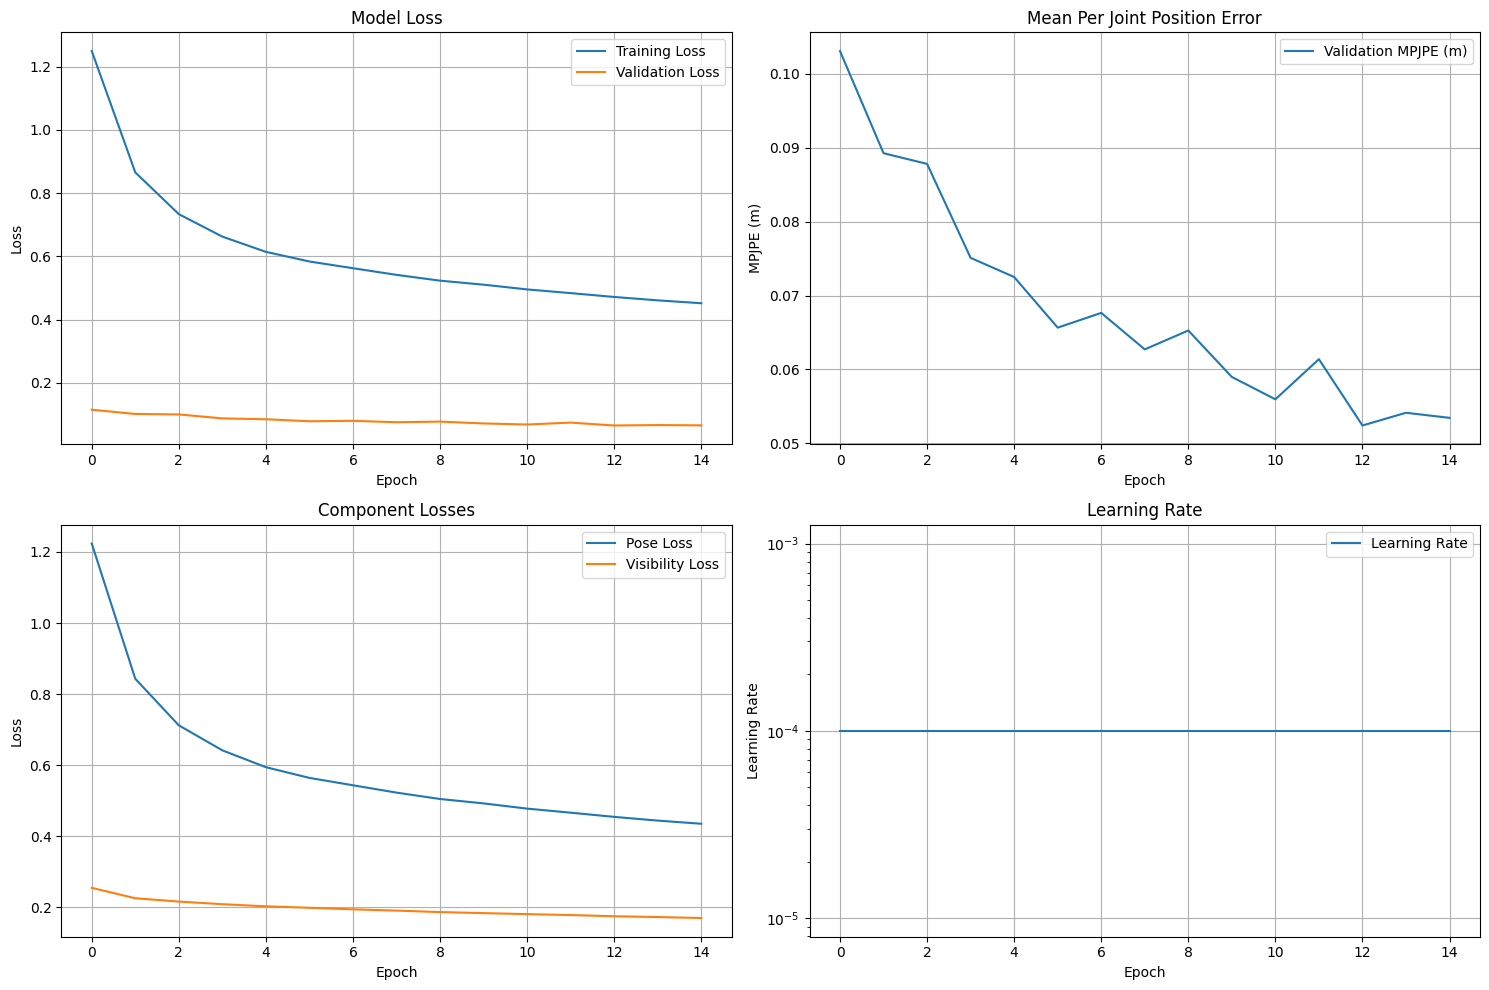

In [ ]:

def plot_training_history(history):
    """Plot training metrics history"""
    plt.figure(figsize=(15, 10))

    # Plot training and validation loss
    plt.subplot(2, 2, 1)
    plt.plot(history['train_loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot MPJPE
    plt.subplot(2, 2, 2)
    plt.plot(history['val_mpjpe'], label='Validation MPJPE (m)')
    plt.title('Mean Per Joint Position Error')
    plt.xlabel('Epoch')
    plt.ylabel('MPJPE (m)')
    plt.legend()
    plt.grid(True)

    # Plot component losses
    plt.subplot(2, 2, 3)
    plt.plot(history['train_pose_loss'], label='Pose Loss')
    plt.plot(history['train_vis_loss'], label='Visibility Loss')
    plt.title('Component Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot learning rate
    plt.subplot(2, 2, 4)
    plt.plot(history['learning_rates'], label='Learning Rate')
    plt.title('Learning Rate')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.yscale('log')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig('results/training_history.png')
    plt.show()


plot_training_history(history)

In [ ]:
import torch
from torch.utils.data import DataLoader
import numpy as np

# Load model
model = ViewpointInvariantPoseNet(num_joints=15, num_iterations=3)
checkpoint = torch.load("/content/models/best_viewpoint_invariant_pose_model.pth")
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()

# Load validation or test dataset
dataset = ITOPDataset(
    depth_path='ITOP_side_test_depth_map.h5',  # Provide the actual path
    label_path='ITOP_side_test_labels.h5',     # Provide the actual path
    split='test',
    only_valid=True
)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)



Keys in label file: ['id', 'image_coordinates', 'is_valid', 'real_world_coordinates', 'segmentation', 'visible_joints']


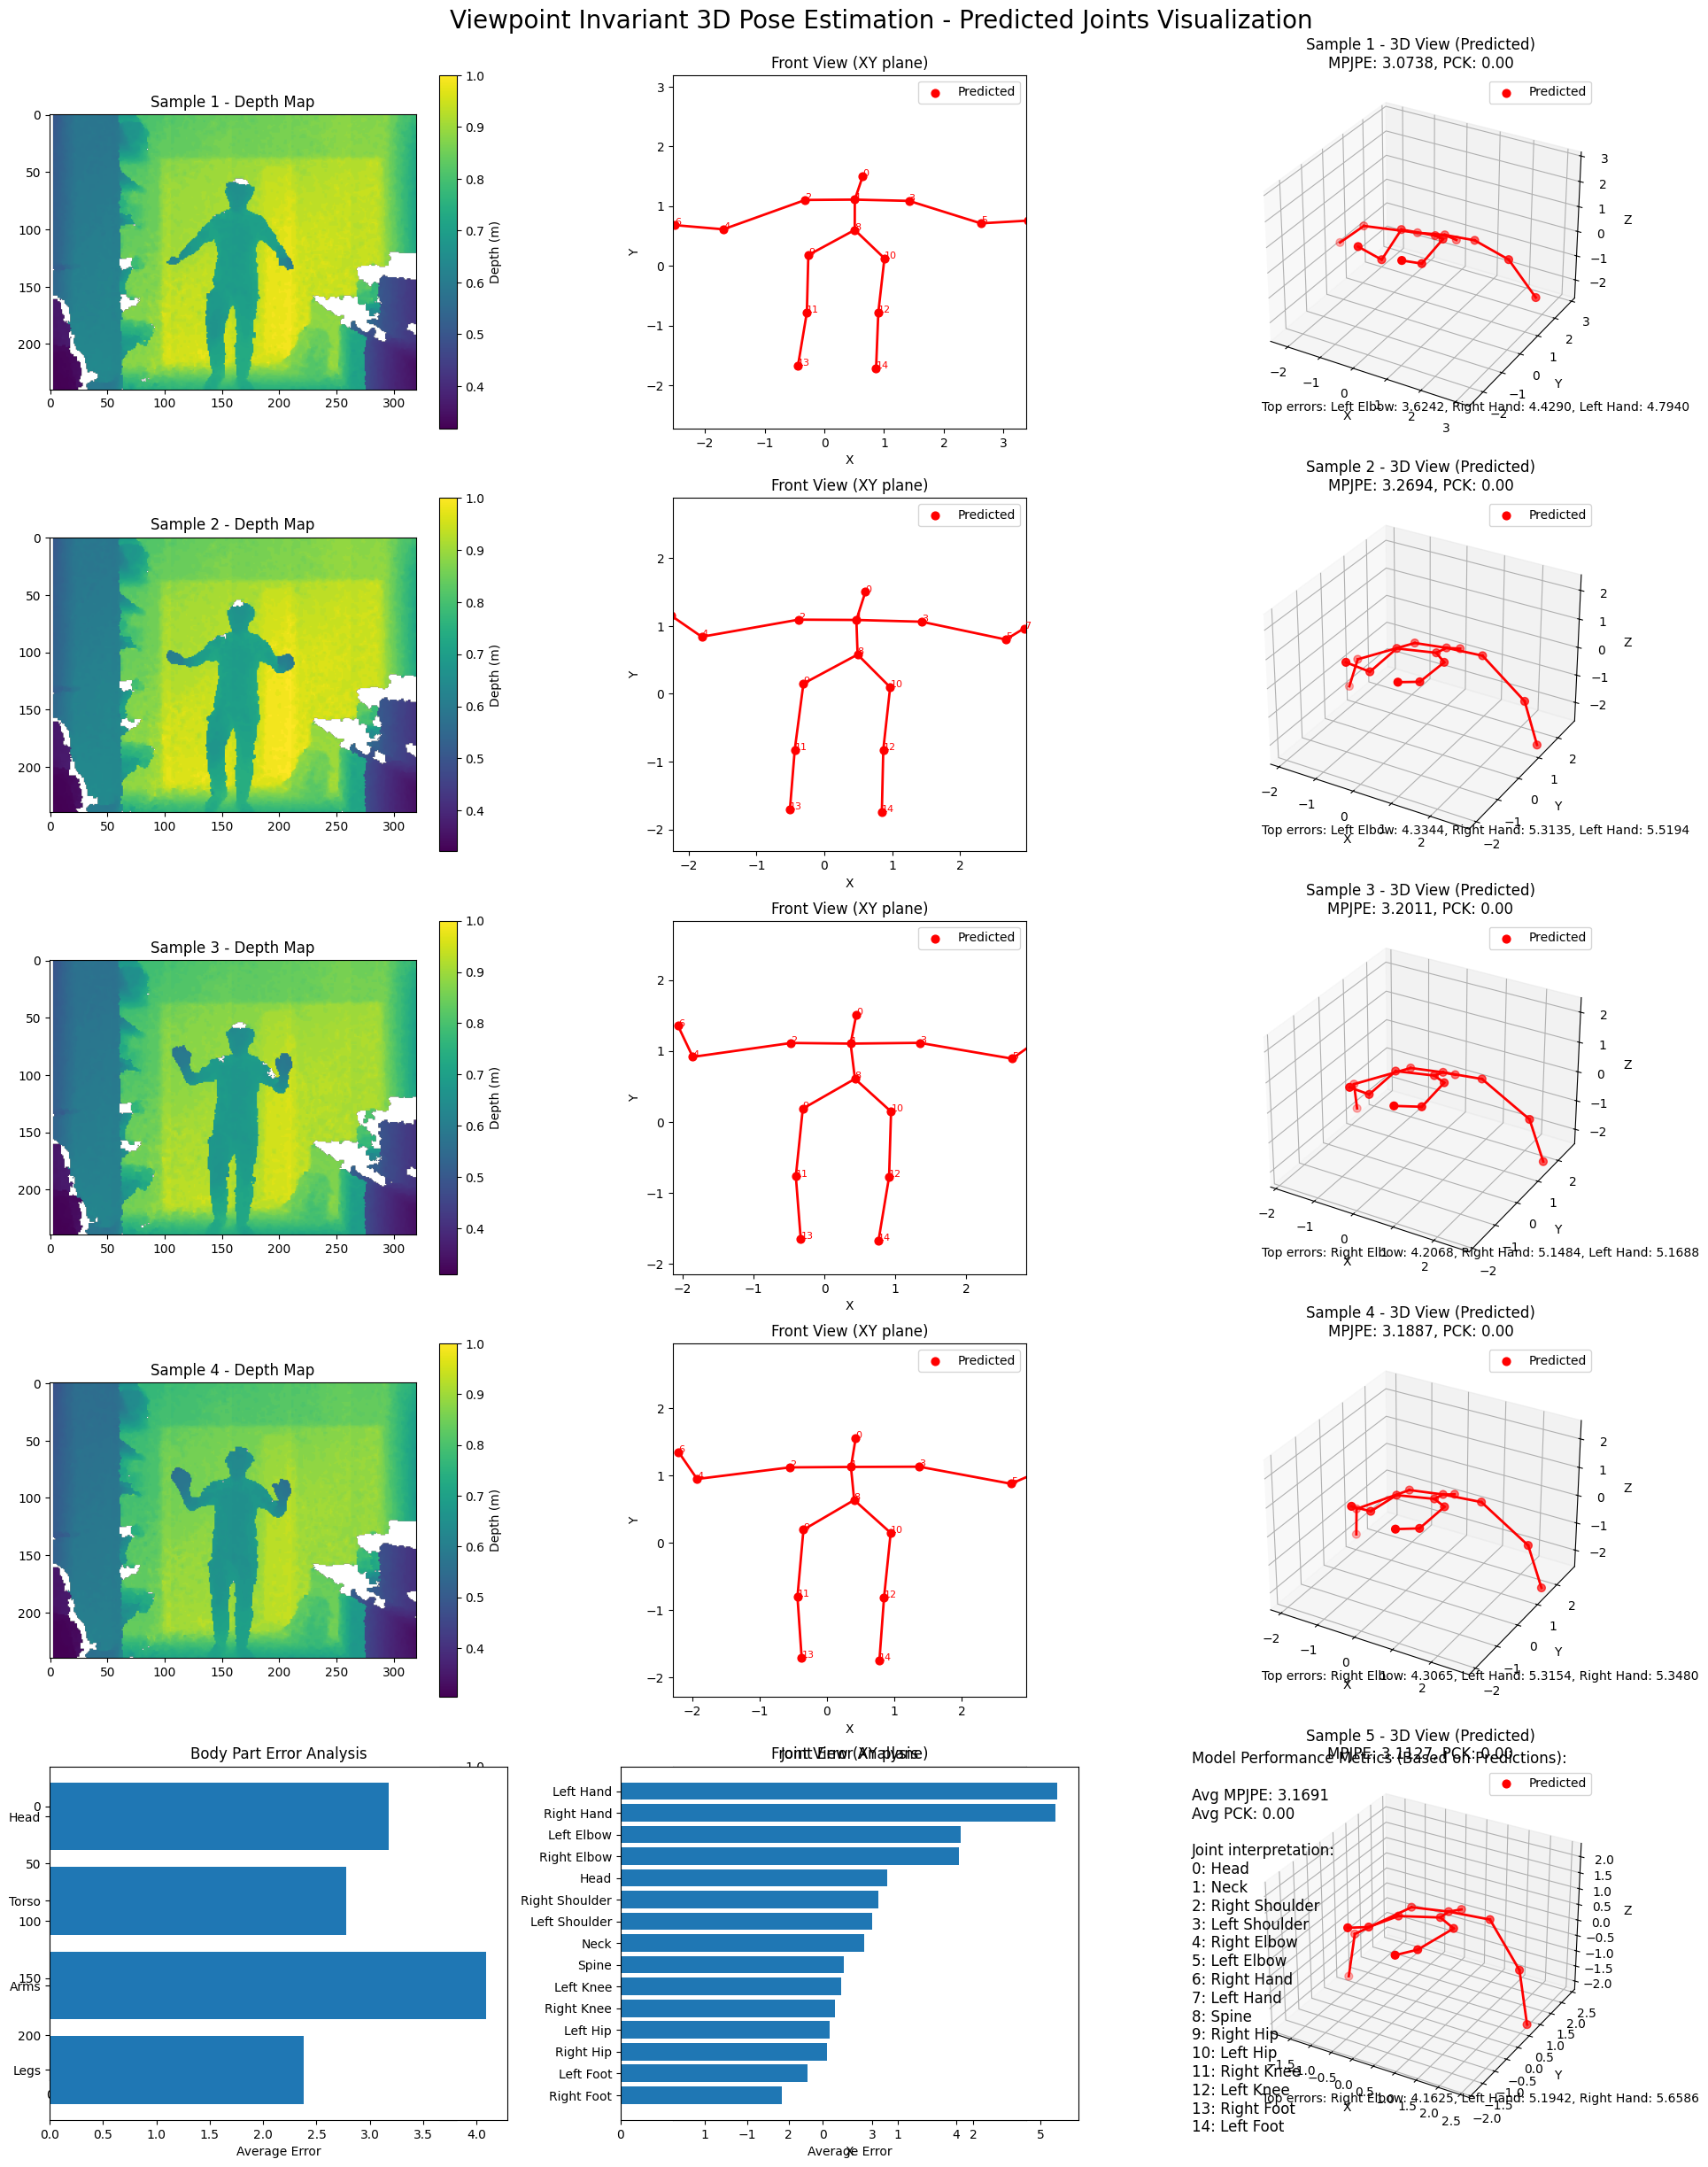


Joint Error Analysis (sorted by highest error):
Left Hand: 5.198359
Right Hand: 5.179511
Left Elbow: 4.047383
Right Elbow: 4.033432
Head: 3.173409
Right Shoulder: 3.071421
Left Shoulder: 2.995302
Neck: 2.903272
Spine: 2.655693
Left Knee: 2.632600
Right Knee: 2.551991
Left Hip: 2.493455
Right Hip: 2.460171
Left Foot: 2.225219
Right Foot: 1.915781

Body Part Error Analysis:
Head: 3.173409
Torso: 2.779483
Arms: 4.087568
Legs: 2.379869


In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch
import matplotlib.cm as cm

samples = []
depth_maps = []

# Assuming `dataloader`, `model`, `device` are defined
for idx, data in enumerate(dataloader):
    if idx >= 5:
        break

    depth_img = data['depth'].squeeze().to(device)
    joints_3d_gt = data['joints_3d'].squeeze().cpu().numpy()

    depth_map = depth_img.cpu().numpy()
    depth_maps.append(depth_map)

    with torch.no_grad():
        pred_joints_3d, _, _ = model(depth_img.unsqueeze(0))

    pred_joints_3d = pred_joints_3d.squeeze().cpu().numpy()
    samples.append((joints_3d_gt, pred_joints_3d))

connections = [
    (0, 1), (1, 2), (1, 3), (2, 4), (3, 5),
    (4, 6), (5, 7), (1, 8), (8, 9), (8, 10),
    (9, 11), (10, 12), (11, 13), (12, 14)
]

def calculate_mpjpe(gt, pred):
    return np.mean(np.linalg.norm(gt - pred, axis=1))

def calculate_pck(gt, pred, threshold=0.15):
    distances = np.linalg.norm(gt - pred, axis=1)
    ref_dist = np.max(np.linalg.norm(gt, axis=1))
    return np.sum(distances < threshold * ref_dist) / len(gt)

joint_names = [
    "Head", "Neck", "Right Shoulder", "Left Shoulder", "Right Elbow",
    "Left Elbow", "Right Hand", "Left Hand", "Spine", "Right Hip",
    "Left Hip", "Right Knee", "Left Knee", "Right Foot", "Left Foot"
]

fig = plt.figure(figsize=(20, 25))

for i, ((gt, pred), depth_map) in enumerate(zip(samples, depth_maps)):
    mpjpe = calculate_mpjpe(gt, pred)
    pck = calculate_pck(gt, pred)

    base_idx = i * 3

    # 1. Depth map visualization
    ax_depth = fig.add_subplot(5, 3, base_idx + 1)
    valid_mask = depth_map > 0
    if np.any(valid_mask):
        vmin = np.min(depth_map[valid_mask])
        vmax = np.max(depth_map[valid_mask])
        depth_vis = depth_map.copy()
        depth_vis[depth_vis == 0] = np.nan
        im = ax_depth.imshow(depth_vis, cmap='viridis', vmin=vmin, vmax=vmax)
        plt.colorbar(im, ax=ax_depth, label='Depth (m)')
    else:
        ax_depth.imshow(depth_map, cmap='viridis')
    ax_depth.set_title(f"Sample {i+1} - Depth Map")

    # 2. Front view (XY plane) - Predicted joints in red
    ax_front = fig.add_subplot(5, 3, base_idx + 2)
    for c in connections:
        ax_front.plot([pred[c[0], 0], pred[c[1], 0]], [pred[c[0], 1], pred[c[1], 1]],
                      color='red', linewidth=2)
    ax_front.scatter(pred[:, 0], pred[:, 1], c='red', s=40, label='Predicted')
    for j in range(len(pred)):
        ax_front.annotate(str(j), (pred[j, 0], pred[j, 1]), color='red', fontsize=8)
    ax_front.set_title("Front View (XY plane)")
    ax_front.set_xlabel("X")
    ax_front.set_ylabel("Y")
    ax_front.legend()
    ax_front.set_aspect('equal')
    all_pts_front = pred[:, :2]
    mid_front = np.mean(all_pts_front, axis=0)
    max_range_front = np.ptp(all_pts_front, axis=0).max() / 2
    ax_front.set_xlim(mid_front[0] - max_range_front, mid_front[0] + max_range_front)
    ax_front.set_ylim(mid_front[1] - max_range_front, mid_front[1] + max_range_front)

    # 3. 3D pose - Predicted joints in red
    ax_3d = fig.add_subplot(5, 3, base_idx + 3, projection='3d')
    for c in connections:
        ax_3d.plot(*zip(pred[c[0]], pred[c[1]]), color='red', linewidth=2)
    ax_3d.scatter(*pred.T, c='red', s=40, label='Predicted')
    ax_3d.set_title(f"Sample {i+1} - 3D View (Predicted)\nMPJPE: {mpjpe:.4f}, PCK: {pck:.2f}")
    ax_3d.set_xlabel("X")
    ax_3d.set_ylabel("Y")
    ax_3d.set_zlabel("Z")
    ax_3d.legend()

    all_pts = pred
    mid = np.mean(all_pts, axis=0)
    max_range = np.ptp(all_pts, axis=0).max() / 2
    ax_3d.set_xlim(mid[0] - max_range, mid[0] + max_range)
    ax_3d.set_ylim(mid[1] - max_range, mid[1] + max_range)
    ax_3d.set_zlim(mid[2] - max_range, mid[2] + max_range)

    joint_errors = np.linalg.norm(gt - pred, axis=1)
    top_error_indices = np.argsort(joint_errors)[-3:]
    error_info = ""
    for idx in top_error_indices:
        error_info += f"{joint_names[idx]}: {joint_errors[idx]:.4f}, "
    ax_3d.text2D(0.05, 0.05, f"Top errors: {error_info[:-2]}",
                 transform=ax_3d.transAxes, fontsize=10)

# Summary subplot
ax_summary = fig.add_subplot(5, 3, 15)
ax_summary.axis('off')
mpjpes = [calculate_mpjpe(gt, pred) for gt, pred in samples]
pcks = [calculate_pck(gt, pred) for gt, pred in samples]

summary = "Model Performance Metrics (Based on Predictions):\n\n"
summary += f"Avg MPJPE: {np.mean(mpjpes):.4f}\nAvg PCK: {np.mean(pcks):.2f}\n\n"
summary += "Joint interpretation:\n"
summary += "\n".join([f"{i}: {name}" for i, name in enumerate(joint_names)])
ax_summary.text(0, 0.5, summary, fontsize=12, va='center')

# Joint-wise error analysis
def analyze_joint_errors(samples):
    joint_errors = np.zeros(15)
    for gt, pred in samples:
        joint_errors += np.linalg.norm(gt - pred, axis=1)
    joint_errors /= len(samples)
    return list(sorted(zip(joint_names, joint_errors), key=lambda x: x[1], reverse=True))

# Body part analysis
body_parts = {
    "Head": ["Head"],
    "Torso": ["Neck", "Spine"],
    "Arms": ["Right Shoulder", "Left Shoulder", "Right Elbow", "Left Elbow", "Right Hand", "Left Hand"],
    "Legs": ["Right Hip", "Left Hip", "Right Knee", "Left Knee", "Right Foot", "Left Foot"]
}

joint_errors = analyze_joint_errors(samples)

ax_errors = fig.add_subplot(5, 3, 14)
joints, errors = zip(*joint_errors)
y_pos = np.arange(len(joints))
ax_errors.barh(y_pos, errors, align='center')
ax_errors.set_yticks(y_pos)
ax_errors.set_yticklabels(joints)
ax_errors.invert_yaxis()
ax_errors.set_xlabel('Average Error')
ax_errors.set_title('Joint Error Analysis')

ax_body_parts = fig.add_subplot(5, 3, 13)
part_errors = {}
for part, part_joints in body_parts.items():
    errors = [err for joint, err in joint_errors if joint in part_joints]
    part_errors[part] = np.mean(errors)

parts = list(part_errors.keys())
values = list(part_errors.values())
y_pos = np.arange(len(parts))
ax_body_parts.barh(y_pos, values, align='center')
ax_body_parts.set_yticks(y_pos)
ax_body_parts.set_yticklabels(parts)
ax_body_parts.invert_yaxis()
ax_body_parts.set_xlabel('Average Error')
ax_body_parts.set_title('Body Part Error Analysis')

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.suptitle("Viewpoint Invariant 3D Pose Estimation - Predicted Joints Visualization", fontsize=20)
plt.show()

print("\nJoint Error Analysis (sorted by highest error):")
for name, err in joint_errors:
    print(f"{name}: {err:.6f}")

print("\nBody Part Error Analysis:")
for part, avg_err in part_errors.items():
    print(f"{part}: {avg_err:.6f}")
